# Diffusion MRI: Basic Physics (Session 2)

By: Diego Hernando

Date: 12/7/2020

**Overview:** This notebook describes the physics of diffusion encoding in MR by simulating a set of spins in brownian motion, in the presence of a diffusion-weighting gradient. 

The additional materials describe more advanced phenomena such as anisotropic diffusion and diffusion-time dependent signals. 


In [1]:
from numpy import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
from IPython.display import clear_output
#%matplotlib inline 
font = {'weight' : 'normal',
        'size'   : 20}

### Define some basics for the Brownian motion simulation

In [49]:
N = 2000 # Number of protons (water molecules)
T = 80 # Diffusion time in ms
dt = 0.1 # Time step in ms
NT = int(T/dt)
D = 2E-3 # Diffusion coefficient in mm2/s

# Define a cell with impermeable walls
cell_radius_x = 8
cell_radius_y = 200
angles = np.linspace(0,2*np.pi,200)

### Calculate and display simulated Brownian motion

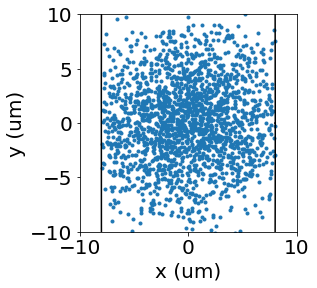

In [50]:
# Initial location of protons
pos0x = 4*rnd.rand(N)-2
pos0y = 4*rnd.rand(N)-2

# Display the initial location of the protons and cell
fig, ax = plt.subplots()
plt.rc('font', **font)
plt.show()
axes = plt.gca()
axes.set_aspect('equal')
axes.set_xlim(-10,10)
axes.set_ylim(-10,10)
points = ax.plot(pos0x,pos0y,'.')[0]
ax.plot(cell_radius_x*np.cos(angles), cell_radius_y*np.sin(angles),'k')

# Start the simulation
posx = np.zeros([N,NT])
posy = np.zeros([N,NT])
posx[:,0] = pos0x
posy[:,0] = pos0y
for kt in range(1,NT):
    # These next two lines introduce brownian motion (in 2D)
    posx[:,kt] = posx[:,kt-1] + np.sqrt(2*dt*D*1E3)*rnd.randn(N)
    posy[:,kt] = posy[:,kt-1] + np.sqrt(2*dt*D*1E3)*rnd.randn(N)  
    
    # Make sure that protons do not leave the cell
    undo = ((posx[:,kt]/cell_radius_x)**2 + (posy[:,kt]/cell_radius_y)**2) > 1   
    posx[undo,kt] = posx[undo,kt-1]
    posy[undo,kt] = posy[undo,kt-1]
    
    # Display the first few steps of the simulation
    if kt<NT/20:
        clear_output(wait=True)
        points = plt.plot(posx[:,kt],posy[:,kt],'.')[0]   
        plt.plot(cell_radius_x*np.cos(angles), cell_radius_y*np.sin(angles),'k')
        plt.xlabel('x (um)')
        plt.ylabel('y (um)')
        axes = plt.gca()
        axes.set_aspect('equal')
        axes.set_xlim(-10,10)
        axes.set_ylim(-10,10)
        plt.show()
        plt.pause(0.001)

### Create a diffusion-weighting gradient (we will assume Gx)

Note that for a given diffusion gradient $G_x$, the magnetic field as a function of $x$ is a ramp with slope $G_x$, ie: $B_0(x) = G_x \cdot x$. So, if we change the diffusion gradient over time as described by our waveform, we end up with a time-varying magnetic field ramp:

$$B_0(x;t) = G_x(t) \cdot x$$

We will also calculate the 'b-value' as a measure of how much diffusion weighting our gradient waveform generates

$$b = \gamma^2 \int_0^T \left( \int_0^t G(\tau) d \tau \right)^2 dt$$

where $\gamma$ is the gyromagnetic ratio ($\gamma/(2 \pi) = 42.58 \times 10^6$ MHz/T) and $T$ is the total duration of the diffusion gradient. 


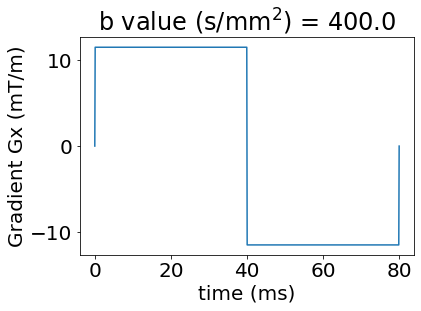

In [51]:
# Generate diffusion gradient
b = 400 # Target diffusion weighting b value, in s/mm^2
t = dt*np.linspace(0,NT,NT)
Gnorm = 0*t;
Gnorm[(t>0)*(t<T/2)] = 1 # In mT/m
Gnorm[(t>T/2)*(t<T)] = -1 # In mT/m

# Calculate b value
gammabar = 42.576E6
gamma = gammabar*2*np.pi
binit = (gamma**2) * np.sum((np.cumsum(Gnorm*1E-3*dt*1E-3))**2)*dt*1E-3*1E-6

# Scale our gradient waveform to match the target b value
G = Gnorm*np.sqrt(b/binit)

# Plot waveform
plt.plot(t,G)    
plt.title('b value (s/mm$^2$) = ' '{:.1f}'.format(b));
plt.xlabel('time (ms)')
plt.ylabel('Gradient Gx (mT/m)')
plt.rc('font', **font)

# Calculate b value  again, just to make sure
bfinal = (gamma**2) * np.sum((np.cumsum(G*1E-3*dt*1E-3))**2)*dt*1E-3*1E-6


### Look at the phase evolution of each of our spins

We just need to keep in mind a couple things: 

We have a **time-dependent magnetic field ramp** introduced by our gradient waveform: $$B_0(x;t) = G_x(t) \cdot x$$

Our protons are moving around in space, in particularly they are moving around in the x direction (movement along y does not matter in this case since our gradient is along x)

The precession frequency of the spin from each proton depends on the magnetic field observed by this proton, as described by the **Larmor equation**: $\omega = \gamma B_0$, and since in our case the magnetic field is ramp-shaped and changing over time, the **precession frequency of each spin** is: 

$$\omega(x;t) = \gamma B_0(x;t) = \gamma G_x(t) \cdot x$$




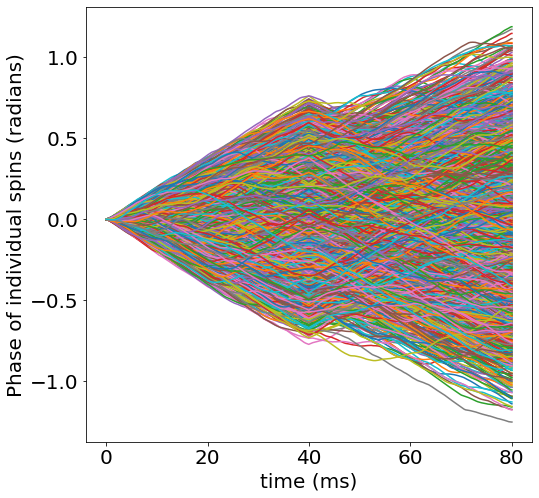

In [52]:

phase = np.zeros([N,NT])
for kt in range(1,NT):
    phase[:,kt] = phase[:,kt-1] + 2*np.pi*gammabar*G[kt]*posx[:,kt]*dt*1E-12
    
plt.figure(figsize=(8,8))    
plt.plot(t,np.transpose(phase[:,:]) );
plt.xlabel('time (ms)')
plt.ylabel('Phase of individual spins (radians)')
plt.rc('font', **font)


### Calculating the total signal from all our spins

Simply the sum of the signals from all spins, normalized by the number of spins for simplicity (ie: the mean of the signals from all spins) 

(0.8979181725680941+0.010708271207269374j)

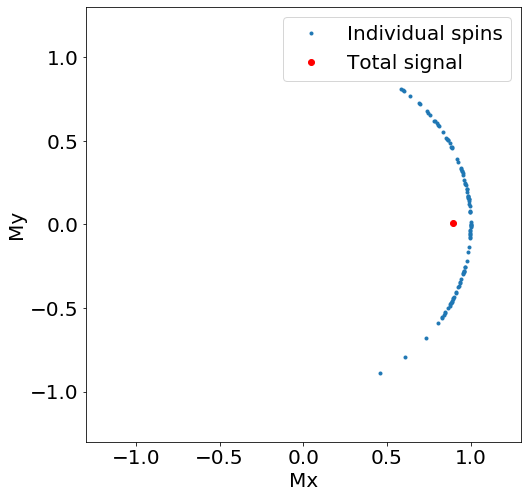

In [53]:
signal_per_spin = np.exp(1j*phase[:,NT-1])

signal_total = np.mean(signal_per_spin)

plt.figure(figsize=(8,8))
plt.plot(np.real(signal_per_spin[1:100]), np.imag(signal_per_spin[1:100]),'.', label='Individual spins')
plt.plot(np.real(signal_total), np.imag(signal_total),'.r', MarkerSize=12, label='Total signal')
plt.legend()
axes = plt.gca()
axes.set_aspect('equal')
axes.set_xlim(-1.3,1.3)
axes.set_ylim(-1.3,1.3)
plt.xlabel('Mx');
plt.ylabel('My');
plt.rc('font', **font)

signal_total

### Calculating the signal across multiple b values

Finally, let's repeat our simulation by scaling our diffusion gradient multiple times with different scaling factors, leading to different b values, and see what signal we get. 

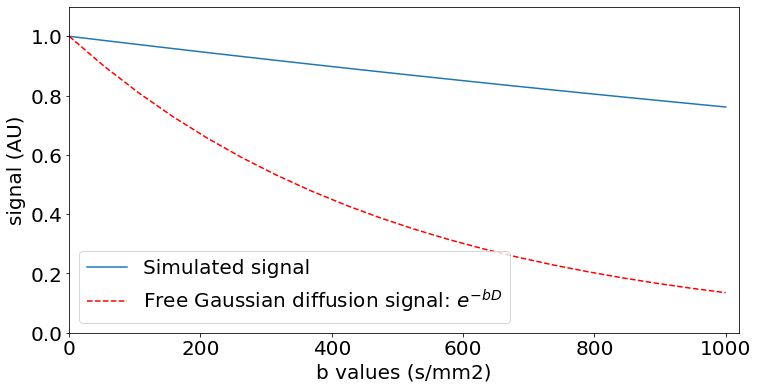

In [56]:
# Now let's get signals across many b values by scaling our gradient
num_b = 20 
b = np.linspace(0,1000,num_b)
G_vals = np.sqrt(b/binit)

b_calc = np.zeros(num_b)

signal = np.zeros(num_b) + 1j*np.zeros(num_b)


for kb in range(num_b):
    G_val = G_vals[kb]
    G = Gnorm*G_val
    b_calc[kb] = (gamma**2) * np.sum((np.cumsum(G*1E-3*dt*1E-3))**2)*dt*1E-3*1E-6
    phase = np.zeros([N,NT])
    for kt in range(1,NT):
        phase[:,kt] = phase[:,kt-1] + 2*np.pi*gammabar*G[kt]*posx[:,kt]*dt*1E-12
    signal[kb] = np.mean(np.exp(1j*phase[:,NT-1]))
    
plt.figure(figsize=(12,6))
plt.plot(b_calc,np.abs(signal),label='Simulated signal')
plt.xlabel('b values (s/mm2)')
plt.ylabel('signal (AU)')
axes = plt.gca()
axes.set_xlim(0,1.02*b[-1])
axes.set_ylim(0,1.1)
    
# Plot standard monoexponential decay, for comparison    
plt.plot(b,np.exp(-b*D),'r--',label='Free Gaussian diffusion signal: $e^{-bD}$')    
plt.legend();
plt.rc('font', **font)

# Plot eye-ball apparent diffusion coefficient (ADC) fitting   
#ADC = 0.4E-3
#plt.plot(b,np.exp(-b*ADC),'m',label='Fitted ADC signal: : $e^{-b ADC}$')    
#plt.legend();
#plt.rc('font', **font)

### Calculating the signal across multiple diffusion directions

Finally, let's repeat our simulation by rotating our diffusion gradient multiple times with different diffusion gradient directions, and see what signal we get. 

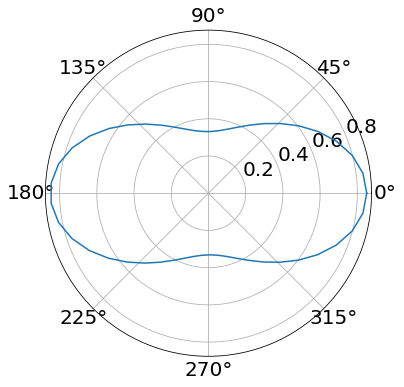

In [57]:
# Now let's get signals across many b values by scaling our gradient
b = 600.0
G_val = np.sqrt(b/binit)
G = Gnorm*G_val
b_calc = (gamma**2) * np.sum((np.cumsum(G*1E-3*dt*1E-3))**2)*dt*1E-3*1E-6
num_angles = 50
G_angles = np.linspace(0,2*np.pi,num_angles)


signal = np.zeros(num_angles) + 1j*np.zeros(num_angles)
for ka in range(num_angles):
    G_angle = G_angles[ka]
    phase = np.zeros([N,NT])
    for kt in range(1,NT):
        phase[:,kt] = phase[:,kt-1] + 2*np.pi*gammabar*G[kt]*posx[:,kt]*np.cos(G_angle)*dt*1E-12 + 2*np.pi*gammabar*G[kt]*posy[:,kt]*np.sin(G_angle)*dt*1E-12
    signal[ka] = np.mean(np.exp(1j*phase[:,NT-1]))
    
plt.figure(figsize=(12,6))
#plt.plot(np.abs(signal)*np.cos(G_angles),np.abs(signal)*np.sin(G_angles),label='Simulated signal')
#axes = plt.gca()
#axes.set_xlim(-1.05,1.05)
#axes.set_ylim(-1.05,1.05)
plt.polar(G_angles, np.abs(signal))    

